In [5]:
# Dataset: CIFAR10

# Architecture: simplified Vision Transformer (ViT) to classify images
# Loss: CrossEntropyLoss
# Optimizer: Adam (lr=0.001)

# Define the batch size for training and testing
batch_size = 64
learning_rate = 0.001

from tqdm import tqdm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose([
transforms.ToTensor(), # Convert PIL image to tensor
transforms.Normalize((0.4914, 0.4822, 0.4465), # Mean for each channel
                    (0.2470, 0.2435, 0.2616)) # Std for each channel
])

# Load the CIFAR-10 training dataset with transformations applied
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
# Load the CIFAR-10 test dataset with the same transformations
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
# Create a data loader for the training set
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, # Number of samples per batch
                        shuffle=True) # Shuffle the data each epoch
# Create a data loader for the test set
test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size, # Same batch size as training
                        shuffle=False) # No shuffling for test data

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
class PatchEmbedding(nn.Module):
    """
    Splits the image into patches and embeds them.
    """
    def __init__(self, in_channels=3, patch_size=4, emb_size=128, img_size=32):
        super().__init__()
        self.patch_size = patch_size
        # We use a simple conv layer to perform patchify + embedding in one step.
        self.proj = nn.Conv2d(in_channels, emb_size,
        kernel_size=patch_size,
        stride=patch_size)
        # Number of patches
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        # Positional embedding
        self.pos_emb = nn.Parameter(torch.zeros(1, num_patches + 1, emb_size))

    def forward(self, x):
        """
        x shape: (B, 3, 32, 32)
        returns: (B, N+1, emb_size)
        """
        B = x.size(0)
        # Conv2d -> (B, emb_size, H’, W’), with H’ and W’ = 32 // patch_size
        x = self.proj(x) # (B, emb_size, H’, W’)
        x = x.flatten(2) # (B, emb_size, H’*W’)
        x = x.transpose(1, 2) # (B, H’*W’, emb_size)
        # Class token
        cls_token = self.cls_token.expand(B, -1, -1) # (B, 1, emb_size)
        x = torch.cat([cls_token, x], dim=1) # (B, N+1, emb_size)
        # Add positional embedding
        x = x + self.pos_emb[:, : x.size(1), :]
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        self.qkv = nn.Linear(emb_size, 3 * emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        # x shape: (B, N, emb_size)
        B, N, _ = x.shape
        qkv = self.qkv(x) # (B, N, 3*emb_size)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # each: (B, num_heads, N, head_dim)
        # Scaled Dot-Product Attention
        # scores shape: (B, num_heads, N, N)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = torch.softmax(scores, dim=-1)
        att = self.att_drop(att)
        # out shape: (B, num_heads, N, head_dim)
        out = torch.matmul(att, v)
        # Combine heads
        out = out.transpose(1, 2) # (B, N, num_heads, head_dim)
        out = out.flatten(2) # (B, N, emb_size)
        out = self.projection(out)
        return out

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, expansion=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadSelfAttention(emb_size, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_size)

        # Feed-forward network
        self.ffn = nn.Sequential(
        nn.Linear(emb_size, expansion * emb_size),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(expansion * emb_size, emb_size)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # Attention block
        x_res = x
        x = self.norm1(x)
        x = self.attn(x)
        x = x_res + self.drop(x)
        # Feed-forward block
        x_res = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = x_res + self.drop(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(self,
        in_channels=3,
        patch_size=4,
        emb_size=128,
        img_size=32,
        num_heads=4,
        num_layers=6,
        num_classes=10,
        dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size,
        img_size)
        self.encoder = nn.Sequential(*[
        TransformerEncoderBlock(
        emb_size=emb_size,
        num_heads=num_heads,
        expansion=4,
        dropout=dropout
        ) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(emb_size)
        self.cls_head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        # x shape: (B, 3, 32, 32)
        x = self.patch_embed(x) # (B, N+1, emb_size)
        x = self.encoder(x) # (B, N+1, emb_size)
        x = self.norm(x) # (B, N+1, emb_size)aa
        # The first token is the class token
        cls_token_final = x[:, 0]
        out = self.cls_head(cls_token_final) # (B, num_classes)
        return out

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:21<00:00, 36.40batch/s]


Epoch [1/20], Loss: 1.7143, Accuracy: 36.19%
Test Accuracy: 43.74%


Epoch 2/20: 100%|██████████| 782/782 [00:21<00:00, 36.70batch/s]


Epoch [2/20], Loss: 1.4178, Accuracy: 47.66%
Test Accuracy: 50.73%


Epoch 3/20: 100%|██████████| 782/782 [00:21<00:00, 35.56batch/s]


Epoch [3/20], Loss: 1.3192, Accuracy: 51.93%
Test Accuracy: 51.86%


Epoch 4/20: 100%|██████████| 782/782 [00:19<00:00, 39.72batch/s]


Epoch [4/20], Loss: 1.2592, Accuracy: 54.25%
Test Accuracy: 54.78%


Epoch 5/20: 100%|██████████| 782/782 [00:19<00:00, 41.12batch/s]


Epoch [5/20], Loss: 1.2176, Accuracy: 55.70%
Test Accuracy: 54.06%


Epoch 6/20: 100%|██████████| 782/782 [00:19<00:00, 41.13batch/s]


Epoch [6/20], Loss: 1.1785, Accuracy: 57.05%
Test Accuracy: 56.76%


Epoch 7/20: 100%|██████████| 782/782 [00:18<00:00, 41.79batch/s]


Epoch [7/20], Loss: 1.1443, Accuracy: 58.57%
Test Accuracy: 58.37%


Epoch 8/20: 100%|██████████| 782/782 [00:18<00:00, 41.38batch/s]


Epoch [8/20], Loss: 1.1124, Accuracy: 59.71%
Test Accuracy: 58.85%


Epoch 9/20: 100%|██████████| 782/782 [00:19<00:00, 40.13batch/s]


Epoch [9/20], Loss: 1.0794, Accuracy: 61.02%
Test Accuracy: 58.77%


Epoch 10/20: 100%|██████████| 782/782 [00:19<00:00, 39.45batch/s]


Epoch [10/20], Loss: 1.0537, Accuracy: 61.82%
Test Accuracy: 59.92%


Epoch 11/20: 100%|██████████| 782/782 [00:19<00:00, 40.30batch/s]


Epoch [11/20], Loss: 1.0248, Accuracy: 62.93%
Test Accuracy: 61.32%


Epoch 12/20: 100%|██████████| 782/782 [00:19<00:00, 40.26batch/s]


Epoch [12/20], Loss: 0.9997, Accuracy: 63.99%
Test Accuracy: 61.20%


Epoch 13/20: 100%|██████████| 782/782 [00:20<00:00, 38.60batch/s]


Epoch [13/20], Loss: 0.9680, Accuracy: 65.05%
Test Accuracy: 61.20%


Epoch 14/20: 100%|██████████| 782/782 [00:21<00:00, 37.18batch/s]


Epoch [14/20], Loss: 0.9436, Accuracy: 65.99%
Test Accuracy: 62.61%


Epoch 15/20: 100%|██████████| 782/782 [00:21<00:00, 36.31batch/s]


Epoch [15/20], Loss: 0.9203, Accuracy: 66.99%
Test Accuracy: 63.19%


Epoch 16/20: 100%|██████████| 782/782 [00:21<00:00, 37.12batch/s]


Epoch [16/20], Loss: 0.8985, Accuracy: 67.55%
Test Accuracy: 62.66%


Epoch 17/20: 100%|██████████| 782/782 [00:20<00:00, 38.72batch/s]


Epoch [17/20], Loss: 0.8659, Accuracy: 68.82%
Test Accuracy: 64.07%


Epoch 18/20: 100%|██████████| 782/782 [00:19<00:00, 39.72batch/s]


Epoch [18/20], Loss: 0.8406, Accuracy: 69.89%
Test Accuracy: 63.78%


Epoch 19/20: 100%|██████████| 782/782 [00:19<00:00, 39.26batch/s]


Epoch [19/20], Loss: 0.8204, Accuracy: 70.39%
Test Accuracy: 64.10%


Epoch 20/20: 100%|██████████| 782/782 [00:19<00:00, 40.38batch/s]


Epoch [20/20], Loss: 0.7928, Accuracy: 71.62%
Test Accuracy: 65.14%


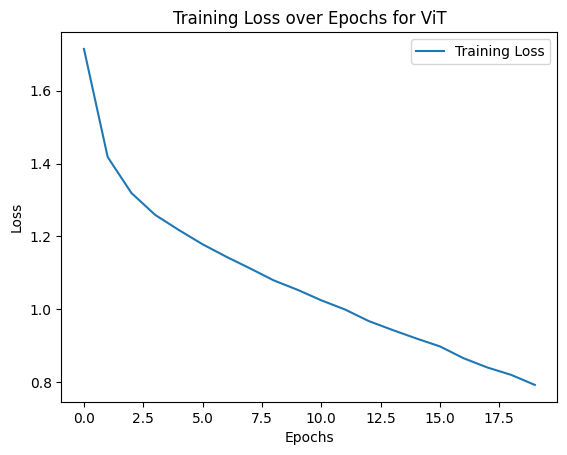

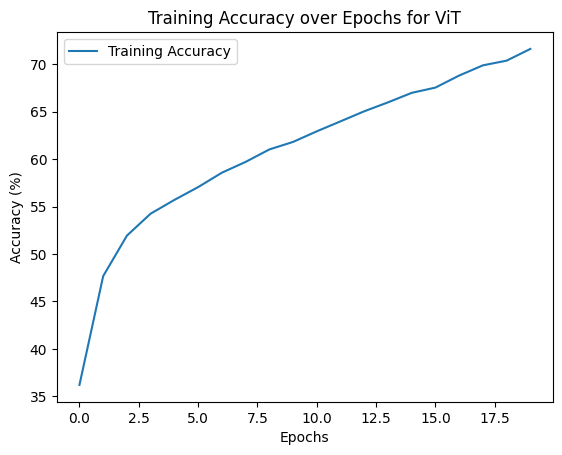

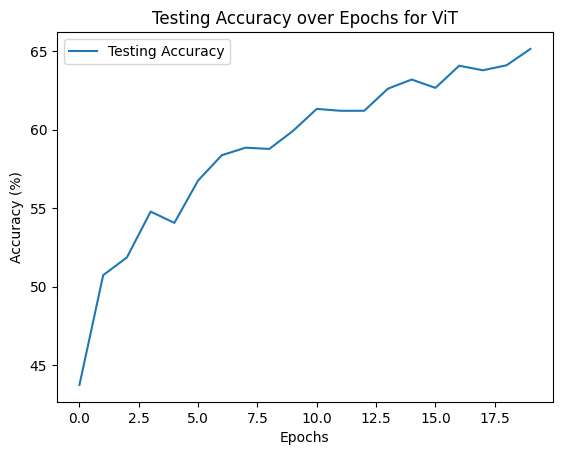

In [8]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

# Implement a ViT with default config. 
model = VisionTransformer()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# check if cuda:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# train over 20 epochs:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss_value = loss(outputs, labels)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss_value.item() * images.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

    epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
    epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total * 100.0
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy: {test_accuracy:.2f}%")

# plots:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss over Epochs for ViT')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs for ViT')
plt.legend()
plt.show()

plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy over Epochs for ViT')
plt.legend()
plt.show()

# plot training loss over epochs
# plot training and testing accuracy over epochs
# compare with CNN models and discuss observations:
    # which model performs better?
    # which model converges faster?


In [ ]:
# 2.
    # train and evaluate with different hyperparameters:

# a) batch size = 64, learning rate = [0.01, 0.001, 0.0001]
    # plot training loss, training accuracy, and testing accuracy over epochs
    # discuss observations:
        # which learning rate performs better?
        # which learning rate converges faster?
# b) use the best learning rate found. Change optimizer to RMSProp.
    # plot training loss, training accuracy, and testing accuracy over epochs
    # discuss observations between Adam and RMSProp optimizers. 


CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:20<00:00, 37.60batch/s]


Epoch [1/20], Loss: 2.1894, Accuracy: 16.57%
Test Accuracy: 17.35%


Epoch 2/20: 100%|██████████| 782/782 [00:19<00:00, 39.56batch/s]


Epoch [2/20], Loss: 2.1592, Accuracy: 17.36%
Test Accuracy: 19.41%


Epoch 3/20: 100%|██████████| 782/782 [00:20<00:00, 39.00batch/s]


Epoch [3/20], Loss: 2.1781, Accuracy: 17.11%
Test Accuracy: 16.45%


Epoch 4/20: 100%|██████████| 782/782 [00:19<00:00, 39.60batch/s]


Epoch [4/20], Loss: 2.1612, Accuracy: 17.41%
Test Accuracy: 16.11%


Epoch 5/20: 100%|██████████| 782/782 [00:19<00:00, 39.90batch/s]


Epoch [5/20], Loss: 2.1674, Accuracy: 17.17%
Test Accuracy: 18.84%


Epoch 6/20: 100%|██████████| 782/782 [00:19<00:00, 39.92batch/s]


Epoch [6/20], Loss: 2.1603, Accuracy: 17.43%
Test Accuracy: 18.68%


Epoch 7/20: 100%|██████████| 782/782 [00:18<00:00, 42.26batch/s]


Epoch [7/20], Loss: 2.1633, Accuracy: 17.46%
Test Accuracy: 18.30%


Epoch 8/20: 100%|██████████| 782/782 [00:18<00:00, 41.44batch/s]


Epoch [8/20], Loss: 2.1710, Accuracy: 17.44%
Test Accuracy: 16.31%


Epoch 9/20: 100%|██████████| 782/782 [00:18<00:00, 41.42batch/s]


Epoch [9/20], Loss: 2.2242, Accuracy: 15.84%
Test Accuracy: 15.92%


Epoch 10/20: 100%|██████████| 782/782 [00:18<00:00, 42.21batch/s]


Epoch [10/20], Loss: 2.1821, Accuracy: 17.14%
Test Accuracy: 17.10%


Epoch 11/20: 100%|██████████| 782/782 [00:18<00:00, 42.59batch/s]


Epoch [11/20], Loss: 2.1797, Accuracy: 17.15%
Test Accuracy: 18.65%


Epoch 12/20: 100%|██████████| 782/782 [00:18<00:00, 42.39batch/s]


Epoch [12/20], Loss: 2.1528, Accuracy: 18.19%
Test Accuracy: 19.30%


Epoch 13/20: 100%|██████████| 782/782 [00:21<00:00, 35.72batch/s]


Epoch [13/20], Loss: 2.1749, Accuracy: 17.37%
Test Accuracy: 16.67%


Epoch 14/20: 100%|██████████| 782/782 [00:21<00:00, 37.24batch/s]


Epoch [14/20], Loss: 2.1710, Accuracy: 17.39%
Test Accuracy: 17.86%


Epoch 15/20: 100%|██████████| 782/782 [00:19<00:00, 39.91batch/s]


Epoch [15/20], Loss: 2.1912, Accuracy: 16.74%
Test Accuracy: 16.86%


Epoch 16/20: 100%|██████████| 782/782 [00:18<00:00, 41.78batch/s]


Epoch [16/20], Loss: 2.1601, Accuracy: 18.08%
Test Accuracy: 18.54%


Epoch 17/20: 100%|██████████| 782/782 [00:19<00:00, 41.05batch/s]


Epoch [17/20], Loss: 2.1539, Accuracy: 18.28%
Test Accuracy: 17.20%


Epoch 18/20: 100%|██████████| 782/782 [00:18<00:00, 41.80batch/s]


Epoch [18/20], Loss: 2.1571, Accuracy: 18.25%
Test Accuracy: 16.95%


Epoch 19/20: 100%|██████████| 782/782 [00:18<00:00, 41.75batch/s]


Epoch [19/20], Loss: 2.1623, Accuracy: 18.38%
Test Accuracy: 16.84%


Epoch 20/20: 100%|██████████| 782/782 [00:19<00:00, 40.64batch/s]


Epoch [20/20], Loss: 2.1689, Accuracy: 17.52%
Test Accuracy: 18.28%


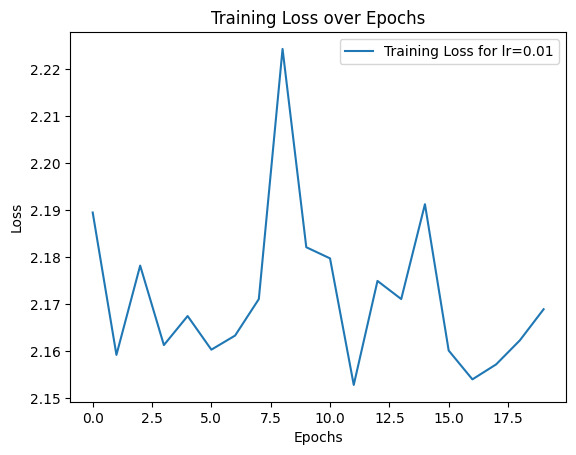

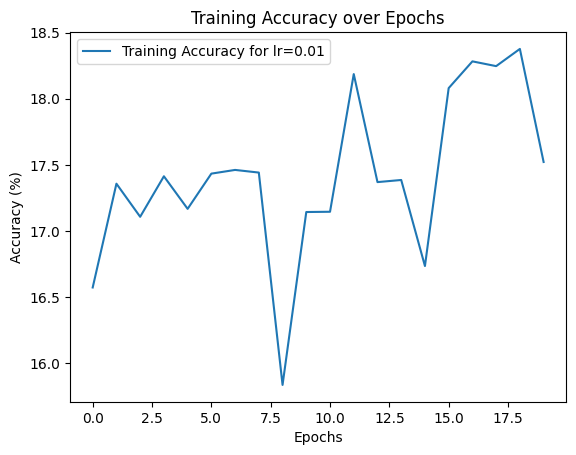

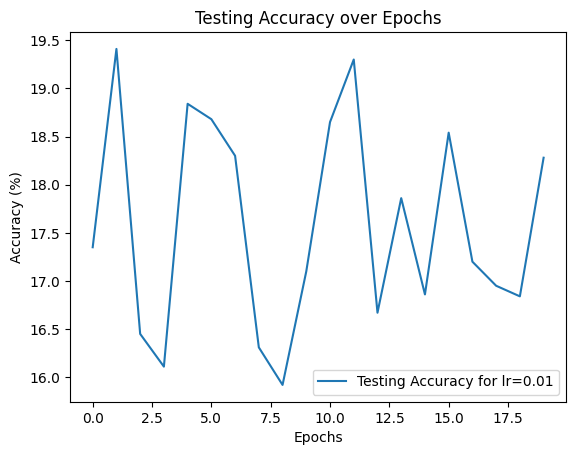

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:18<00:00, 42.55batch/s]


Epoch [1/20], Loss: 1.7014, Accuracy: 36.63%
Test Accuracy: 45.81%


Epoch 2/20: 100%|██████████| 782/782 [00:18<00:00, 41.73batch/s]


Epoch [2/20], Loss: 1.4205, Accuracy: 48.17%
Test Accuracy: 51.60%


Epoch 3/20: 100%|██████████| 782/782 [00:19<00:00, 39.39batch/s]


Epoch [3/20], Loss: 1.3119, Accuracy: 52.04%
Test Accuracy: 53.76%


Epoch 4/20: 100%|██████████| 782/782 [00:22<00:00, 34.86batch/s]


Epoch [4/20], Loss: 1.2501, Accuracy: 54.73%
Test Accuracy: 56.16%


Epoch 5/20: 100%|██████████| 782/782 [00:19<00:00, 39.90batch/s]


Epoch [5/20], Loss: 1.2117, Accuracy: 55.93%
Test Accuracy: 56.78%


Epoch 6/20: 100%|██████████| 782/782 [00:18<00:00, 43.11batch/s]


Epoch [6/20], Loss: 1.1613, Accuracy: 57.53%
Test Accuracy: 57.43%


Epoch 7/20: 100%|██████████| 782/782 [00:18<00:00, 43.06batch/s]


Epoch [7/20], Loss: 1.1233, Accuracy: 59.06%
Test Accuracy: 57.24%


Epoch 8/20: 100%|██████████| 782/782 [00:18<00:00, 42.38batch/s]


Epoch [8/20], Loss: 1.0894, Accuracy: 60.51%
Test Accuracy: 60.10%


Epoch 9/20: 100%|██████████| 782/782 [00:18<00:00, 43.18batch/s]


Epoch [9/20], Loss: 1.0552, Accuracy: 61.64%
Test Accuracy: 59.61%


Epoch 10/20: 100%|██████████| 782/782 [00:18<00:00, 42.96batch/s]


Epoch [10/20], Loss: 1.0235, Accuracy: 62.77%
Test Accuracy: 60.89%


Epoch 11/20: 100%|██████████| 782/782 [00:18<00:00, 43.33batch/s]


Epoch [11/20], Loss: 0.9972, Accuracy: 63.80%
Test Accuracy: 61.33%


Epoch 12/20: 100%|██████████| 782/782 [00:18<00:00, 42.99batch/s]


Epoch [12/20], Loss: 0.9656, Accuracy: 64.92%
Test Accuracy: 62.40%


Epoch 13/20: 100%|██████████| 782/782 [00:18<00:00, 43.33batch/s]


Epoch [13/20], Loss: 0.9427, Accuracy: 65.96%
Test Accuracy: 63.11%


Epoch 14/20: 100%|██████████| 782/782 [00:18<00:00, 43.37batch/s]


Epoch [14/20], Loss: 0.9143, Accuracy: 66.74%
Test Accuracy: 64.70%


Epoch 15/20: 100%|██████████| 782/782 [00:18<00:00, 43.02batch/s]


Epoch [15/20], Loss: 0.8929, Accuracy: 67.56%
Test Accuracy: 64.21%


Epoch 16/20: 100%|██████████| 782/782 [00:17<00:00, 43.45batch/s]


Epoch [16/20], Loss: 0.8647, Accuracy: 68.44%
Test Accuracy: 63.98%


Epoch 17/20: 100%|██████████| 782/782 [00:18<00:00, 43.35batch/s]


Epoch [17/20], Loss: 0.8417, Accuracy: 69.46%
Test Accuracy: 64.44%


Epoch 18/20: 100%|██████████| 782/782 [00:18<00:00, 42.95batch/s]


Epoch [18/20], Loss: 0.8126, Accuracy: 70.45%
Test Accuracy: 64.91%


Epoch 19/20: 100%|██████████| 782/782 [00:18<00:00, 42.59batch/s]


Epoch [19/20], Loss: 0.7907, Accuracy: 71.30%
Test Accuracy: 65.94%


Epoch 20/20: 100%|██████████| 782/782 [00:18<00:00, 41.95batch/s]


Epoch [20/20], Loss: 0.7647, Accuracy: 72.14%
Test Accuracy: 66.08%


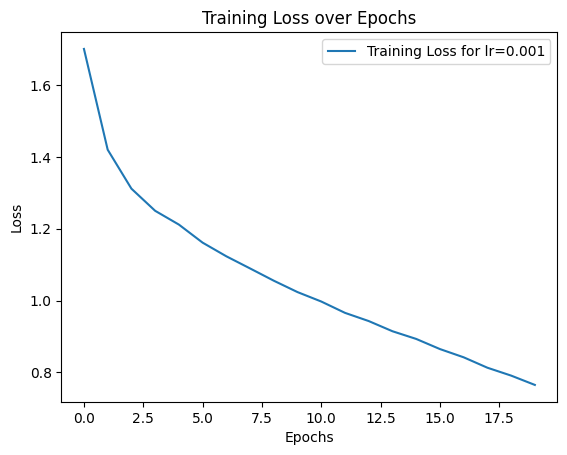

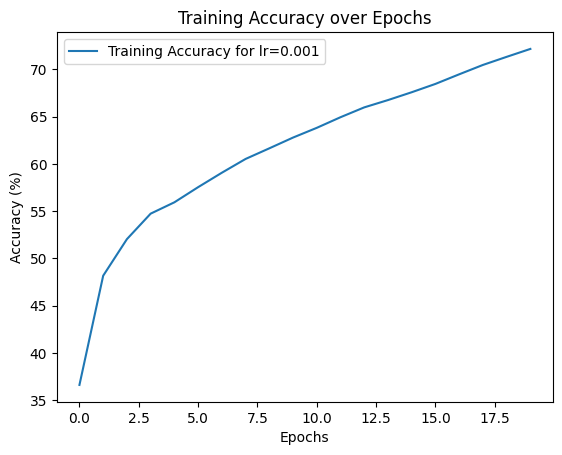

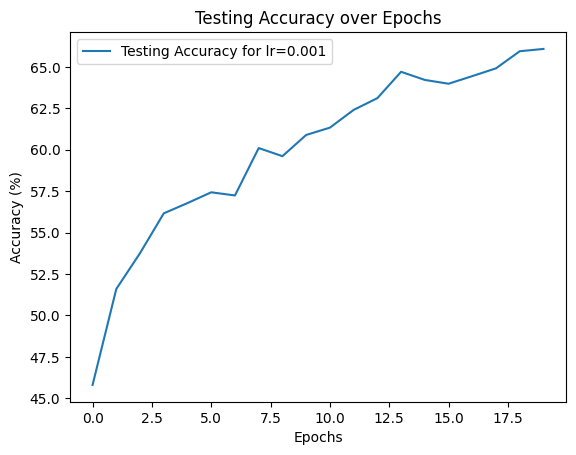

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:19<00:00, 41.10batch/s]


Epoch [1/20], Loss: 1.7473, Accuracy: 35.39%
Test Accuracy: 43.25%


Epoch 2/20: 100%|██████████| 782/782 [00:18<00:00, 41.62batch/s]


Epoch [2/20], Loss: 1.4664, Accuracy: 46.31%
Test Accuracy: 49.78%


Epoch 3/20: 100%|██████████| 782/782 [00:20<00:00, 38.53batch/s]


Epoch [3/20], Loss: 1.3168, Accuracy: 51.85%
Test Accuracy: 52.54%


Epoch 4/20: 100%|██████████| 782/782 [00:18<00:00, 42.03batch/s]


Epoch [4/20], Loss: 1.2122, Accuracy: 56.05%
Test Accuracy: 55.55%


Epoch 5/20: 100%|██████████| 782/782 [00:18<00:00, 41.80batch/s]


Epoch [5/20], Loss: 1.1400, Accuracy: 58.61%
Test Accuracy: 58.81%


Epoch 6/20: 100%|██████████| 782/782 [00:20<00:00, 37.90batch/s]


Epoch [6/20], Loss: 1.0772, Accuracy: 61.13%
Test Accuracy: 60.85%


Epoch 7/20: 100%|██████████| 782/782 [00:19<00:00, 40.65batch/s]


Epoch [7/20], Loss: 1.0251, Accuracy: 62.99%
Test Accuracy: 60.92%


Epoch 8/20: 100%|██████████| 782/782 [00:20<00:00, 37.54batch/s]


Epoch [8/20], Loss: 0.9778, Accuracy: 64.89%
Test Accuracy: 63.18%


Epoch 9/20: 100%|██████████| 782/782 [00:21<00:00, 35.76batch/s]


Epoch [9/20], Loss: 0.9374, Accuracy: 66.33%
Test Accuracy: 64.07%


Epoch 10/20: 100%|██████████| 782/782 [00:20<00:00, 38.55batch/s]


Epoch [10/20], Loss: 0.8999, Accuracy: 67.57%
Test Accuracy: 65.03%


Epoch 11/20: 100%|██████████| 782/782 [00:20<00:00, 38.97batch/s]


Epoch [11/20], Loss: 0.8615, Accuracy: 69.12%
Test Accuracy: 66.24%


Epoch 12/20: 100%|██████████| 782/782 [00:21<00:00, 35.77batch/s]


Epoch [12/20], Loss: 0.8304, Accuracy: 70.28%
Test Accuracy: 66.22%


Epoch 13/20: 100%|██████████| 782/782 [00:22<00:00, 34.04batch/s]


Epoch [13/20], Loss: 0.8014, Accuracy: 71.29%
Test Accuracy: 66.73%


Epoch 14/20: 100%|██████████| 782/782 [00:21<00:00, 37.02batch/s]


Epoch [14/20], Loss: 0.7753, Accuracy: 72.28%
Test Accuracy: 68.42%


Epoch 15/20: 100%|██████████| 782/782 [00:20<00:00, 37.95batch/s]


Epoch [15/20], Loss: 0.7430, Accuracy: 73.32%
Test Accuracy: 68.22%


Epoch 16/20: 100%|██████████| 782/782 [00:19<00:00, 40.32batch/s]


Epoch [16/20], Loss: 0.7193, Accuracy: 74.26%
Test Accuracy: 68.53%


Epoch 17/20: 100%|██████████| 782/782 [00:22<00:00, 34.56batch/s]


Epoch [17/20], Loss: 0.6930, Accuracy: 75.30%
Test Accuracy: 68.35%


Epoch 18/20: 100%|██████████| 782/782 [00:22<00:00, 35.51batch/s]


Epoch [18/20], Loss: 0.6669, Accuracy: 76.04%
Test Accuracy: 69.00%


Epoch 19/20: 100%|██████████| 782/782 [00:19<00:00, 40.18batch/s]


Epoch [19/20], Loss: 0.6453, Accuracy: 76.94%
Test Accuracy: 68.83%


Epoch 20/20: 100%|██████████| 782/782 [00:18<00:00, 41.34batch/s]


Epoch [20/20], Loss: 0.6235, Accuracy: 77.70%
Test Accuracy: 69.48%


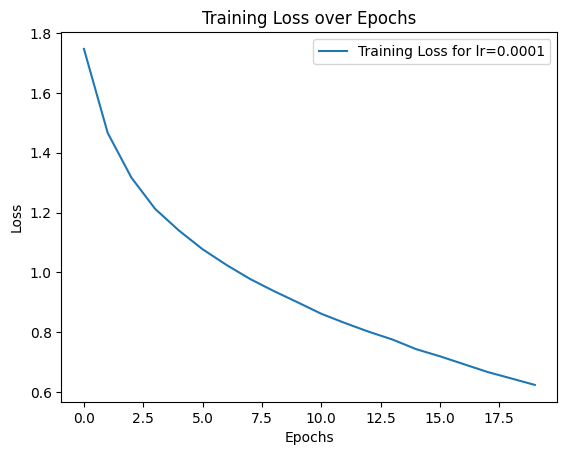

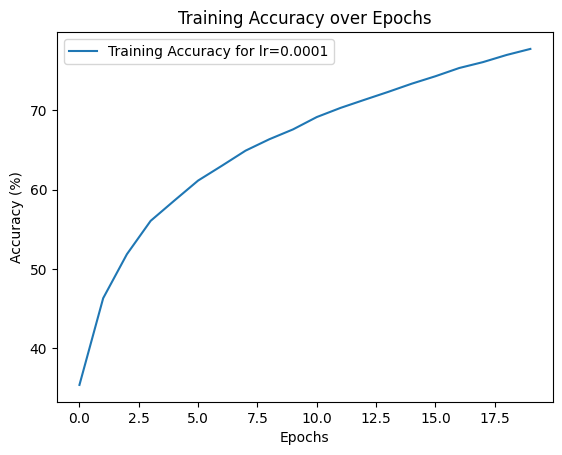

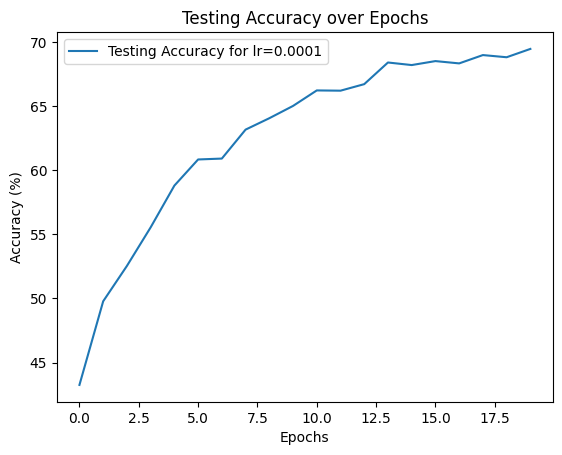

In [12]:
# a)  batch size = 64, learning rate = [0.01, 0.001, 0.0001]
batch_size = 64

learning_rates = [0.01, 0.001, 0.0001]

for learning_rate in learning_rates:
    # init:
    model = VisionTransformer()
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # check if cuda:
    if torch.cuda.is_available():
        print("CUDA is available. Training on GPU.")
    else:
        print("CUDA is not available. Training on CPU.")

    # train over 20 epochs:
    num_epochs = 20
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate over the training data
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss_value = loss(outputs, labels)  # Compute loss
            loss_value.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss_value.item() * images.size(0)  # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
            total += labels.size(0)  # Total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

        epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
        epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation for testing
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total * 100.0
        test_accuracies.append(test_accuracy)

        print(f"Test Accuracy: {test_accuracy:.2f}%")
    # plot for each LR: 
    plt.plot(train_losses, label=f'Training Loss for lr={learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label=f'Training Accuracy for lr={learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy over Epochs')
    plt.legend()
    plt.show()

    plt.plot(test_accuracies, label=f'Testing Accuracy for lr={learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Testing Accuracy over Epochs')
    plt.legend()
    plt.show()
    


CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:20<00:00, 37.78batch/s]


Epoch [1/20], Loss: 1.7517, Accuracy: 35.04%
Test Accuracy: 38.75%


Epoch 2/20: 100%|██████████| 782/782 [00:21<00:00, 36.48batch/s]


Epoch [2/20], Loss: 1.4980, Accuracy: 45.27%
Test Accuracy: 46.23%


Epoch 3/20: 100%|██████████| 782/782 [00:21<00:00, 36.99batch/s]


Epoch [3/20], Loss: 1.3474, Accuracy: 51.15%
Test Accuracy: 48.12%


Epoch 4/20: 100%|██████████| 782/782 [00:20<00:00, 38.96batch/s]


Epoch [4/20], Loss: 1.2415, Accuracy: 55.20%
Test Accuracy: 53.85%


Epoch 5/20: 100%|██████████| 782/782 [00:18<00:00, 41.83batch/s]


Epoch [5/20], Loss: 1.1657, Accuracy: 57.88%
Test Accuracy: 56.37%


Epoch 6/20: 100%|██████████| 782/782 [00:18<00:00, 41.23batch/s]


Epoch [6/20], Loss: 1.1035, Accuracy: 60.26%
Test Accuracy: 59.52%


Epoch 7/20: 100%|██████████| 782/782 [00:18<00:00, 41.91batch/s]


Epoch [7/20], Loss: 1.0484, Accuracy: 62.20%
Test Accuracy: 57.01%


Epoch 8/20: 100%|██████████| 782/782 [00:18<00:00, 42.01batch/s]


Epoch [8/20], Loss: 1.0005, Accuracy: 64.05%
Test Accuracy: 56.42%


Epoch 9/20: 100%|██████████| 782/782 [00:19<00:00, 40.77batch/s]


Epoch [9/20], Loss: 0.9579, Accuracy: 65.60%
Test Accuracy: 63.41%


Epoch 10/20: 100%|██████████| 782/782 [00:18<00:00, 42.06batch/s]


Epoch [10/20], Loss: 0.9207, Accuracy: 67.03%
Test Accuracy: 62.92%


Epoch 11/20: 100%|██████████| 782/782 [00:18<00:00, 41.94batch/s]


Epoch [11/20], Loss: 0.8837, Accuracy: 68.38%
Test Accuracy: 62.45%


Epoch 12/20: 100%|██████████| 782/782 [00:19<00:00, 40.45batch/s]


Epoch [12/20], Loss: 0.8509, Accuracy: 69.53%
Test Accuracy: 62.28%


Epoch 13/20: 100%|██████████| 782/782 [00:19<00:00, 40.47batch/s]


Epoch [13/20], Loss: 0.8200, Accuracy: 70.72%
Test Accuracy: 61.58%


Epoch 14/20: 100%|██████████| 782/782 [00:18<00:00, 41.55batch/s]


Epoch [14/20], Loss: 0.7912, Accuracy: 72.04%
Test Accuracy: 65.00%


Epoch 15/20: 100%|██████████| 782/782 [00:19<00:00, 41.09batch/s]


Epoch [15/20], Loss: 0.7630, Accuracy: 72.83%
Test Accuracy: 66.54%


Epoch 16/20: 100%|██████████| 782/782 [00:18<00:00, 42.17batch/s]


Epoch [16/20], Loss: 0.7343, Accuracy: 73.80%
Test Accuracy: 67.43%


Epoch 17/20: 100%|██████████| 782/782 [00:18<00:00, 42.56batch/s]


Epoch [17/20], Loss: 0.7111, Accuracy: 74.73%
Test Accuracy: 67.32%


Epoch 18/20: 100%|██████████| 782/782 [00:19<00:00, 40.91batch/s]


Epoch [18/20], Loss: 0.6820, Accuracy: 75.73%
Test Accuracy: 66.01%


Epoch 19/20: 100%|██████████| 782/782 [00:18<00:00, 42.60batch/s]


Epoch [19/20], Loss: 0.6592, Accuracy: 76.53%
Test Accuracy: 68.14%


Epoch 20/20: 100%|██████████| 782/782 [00:18<00:00, 42.62batch/s]


Epoch [20/20], Loss: 0.6334, Accuracy: 77.57%
Test Accuracy: 66.90%


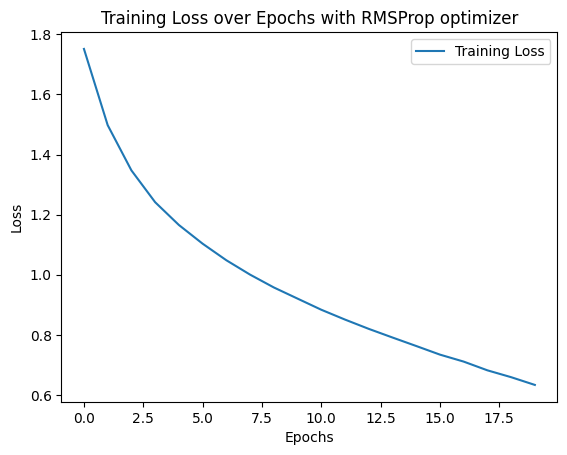

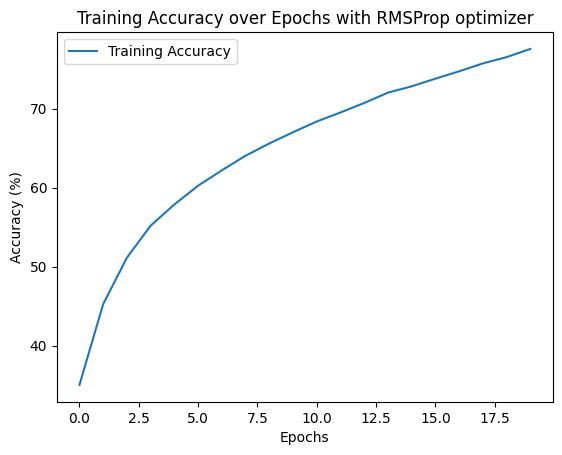

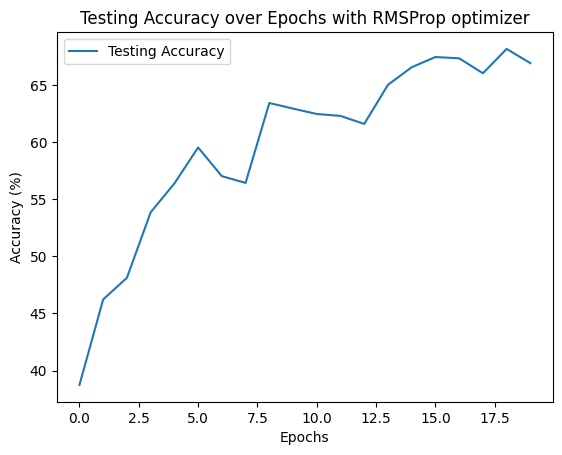

In [13]:
# b) use the best learning rate found. Change optimizer to RMSProp. 


# reset batch size:
batch_size = 64
# Create a data loader for the training set
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, # Number of samples per batch
                        shuffle=True) # Shuffle the data each epoch
    # Create a data loader for the test set
test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size, # Same batch size as training
                        shuffle=False) # No shuffling for test data
# init:
learning_rate = 0.0001 # best LR found in previous step
model = VisionTransformer()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# check if cuda:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# train over 20 epochs:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss_value = loss(outputs, labels)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss_value.item() * images.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

    epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
    epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total * 100.0
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy: {test_accuracy:.2f}%")

# plots:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss over Epochs with RMSProp optimizer')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs with RMSProp optimizer')
plt.legend()
plt.show()

plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy over Epochs with RMSProp optimizer')
plt.legend()
plt.show()



In [ ]:
# 3. 
    # Investigate the effect of different model designs. Change num_layers to 4 and 8. 
    # plot training loss, training accuracy, and testing accuracy over epochs
    # discuss how number of Transformer layers affects performance and convergence. 


In [16]:
### NUM_LAYERS = 4

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
class PatchEmbedding(nn.Module):
    """
    Splits the image into patches and embeds them.
    """
    def __init__(self, in_channels=3, patch_size=4, emb_size=128, img_size=32):
        super().__init__()
        self.patch_size = patch_size
        # We use a simple conv layer to perform patchify + embedding in one step.
        self.proj = nn.Conv2d(in_channels, emb_size,
        kernel_size=patch_size,
        stride=patch_size)
        # Number of patches
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        # Positional embedding
        self.pos_emb = nn.Parameter(torch.zeros(1, num_patches + 1, emb_size))

    def forward(self, x):
        """
        x shape: (B, 3, 32, 32)
        returns: (B, N+1, emb_size)
        """
        B = x.size(0)
        # Conv2d -> (B, emb_size, H’, W’), with H’ and W’ = 32 // patch_size
        x = self.proj(x) # (B, emb_size, H’, W’)
        x = x.flatten(2) # (B, emb_size, H’*W’)
        x = x.transpose(1, 2) # (B, H’*W’, emb_size)
        # Class token
        cls_token = self.cls_token.expand(B, -1, -1) # (B, 1, emb_size)
        x = torch.cat([cls_token, x], dim=1) # (B, N+1, emb_size)
        # Add positional embedding
        x = x + self.pos_emb[:, : x.size(1), :]
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        self.qkv = nn.Linear(emb_size, 3 * emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        # x shape: (B, N, emb_size)
        B, N, _ = x.shape
        qkv = self.qkv(x) # (B, N, 3*emb_size)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # each: (B, num_heads, N, head_dim)
        # Scaled Dot-Product Attention
        # scores shape: (B, num_heads, N, N)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = torch.softmax(scores, dim=-1)
        att = self.att_drop(att)
        # out shape: (B, num_heads, N, head_dim)
        out = torch.matmul(att, v)
        # Combine heads
        out = out.transpose(1, 2) # (B, N, num_heads, head_dim)
        out = out.flatten(2) # (B, N, emb_size)
        out = self.projection(out)
        return out

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, expansion=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadSelfAttention(emb_size, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_size)

        # Feed-forward network
        self.ffn = nn.Sequential(
        nn.Linear(emb_size, expansion * emb_size),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(expansion * emb_size, emb_size)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # Attention block
        x_res = x
        x = self.norm1(x)
        x = self.attn(x)
        x = x_res + self.drop(x)
        # Feed-forward block
        x_res = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = x_res + self.drop(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(self,
        in_channels=3,
        patch_size=4,
        emb_size=128,
        img_size=32,
        num_heads=4,
        num_layers=4,
        num_classes=10,
        dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size,
        img_size)
        self.encoder = nn.Sequential(*[
        TransformerEncoderBlock(
        emb_size=emb_size,
        num_heads=num_heads,
        expansion=4,
        dropout=dropout
        ) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(emb_size)
        self.cls_head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        # x shape: (B, 3, 32, 32)
        x = self.patch_embed(x) # (B, N+1, emb_size)
        x = self.encoder(x) # (B, N+1, emb_size)
        x = self.norm(x) # (B, N+1, emb_size)aa
        # The first token is the class token
        cls_token_final = x[:, 0]
        out = self.cls_head(cls_token_final) # (B, num_classes)
        return out

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:16<00:00, 46.54batch/s]


Epoch [1/20], Loss: 1.7853, Accuracy: 33.94%
Test Accuracy: 42.81%


Epoch 2/20: 100%|██████████| 782/782 [00:16<00:00, 48.01batch/s]


Epoch [2/20], Loss: 1.5118, Accuracy: 44.84%
Test Accuracy: 49.66%


Epoch 3/20: 100%|██████████| 782/782 [00:16<00:00, 48.70batch/s]


Epoch [3/20], Loss: 1.3544, Accuracy: 50.77%
Test Accuracy: 54.21%


Epoch 4/20: 100%|██████████| 782/782 [00:16<00:00, 48.39batch/s]


Epoch [4/20], Loss: 1.2490, Accuracy: 54.82%
Test Accuracy: 55.82%


Epoch 5/20: 100%|██████████| 782/782 [00:15<00:00, 49.00batch/s]


Epoch [5/20], Loss: 1.1740, Accuracy: 57.70%
Test Accuracy: 58.91%


Epoch 6/20: 100%|██████████| 782/782 [00:15<00:00, 49.06batch/s]


Epoch [6/20], Loss: 1.1103, Accuracy: 59.96%
Test Accuracy: 60.88%


Epoch 7/20: 100%|██████████| 782/782 [00:15<00:00, 49.54batch/s]


Epoch [7/20], Loss: 1.0583, Accuracy: 61.94%
Test Accuracy: 60.70%


Epoch 8/20: 100%|██████████| 782/782 [00:15<00:00, 51.44batch/s]


Epoch [8/20], Loss: 1.0104, Accuracy: 63.75%
Test Accuracy: 62.09%


Epoch 9/20: 100%|██████████| 782/782 [00:15<00:00, 51.20batch/s]


Epoch [9/20], Loss: 0.9709, Accuracy: 65.26%
Test Accuracy: 63.82%


Epoch 10/20: 100%|██████████| 782/782 [00:15<00:00, 51.88batch/s]


Epoch [10/20], Loss: 0.9317, Accuracy: 66.45%
Test Accuracy: 64.83%


Epoch 11/20: 100%|██████████| 782/782 [00:16<00:00, 48.36batch/s]


Epoch [11/20], Loss: 0.8922, Accuracy: 67.93%
Test Accuracy: 64.99%


Epoch 12/20: 100%|██████████| 782/782 [00:16<00:00, 48.22batch/s]


Epoch [12/20], Loss: 0.8631, Accuracy: 69.04%
Test Accuracy: 66.00%


Epoch 13/20: 100%|██████████| 782/782 [00:15<00:00, 49.27batch/s]


Epoch [13/20], Loss: 0.8366, Accuracy: 69.82%
Test Accuracy: 67.05%


Epoch 14/20: 100%|██████████| 782/782 [00:15<00:00, 49.28batch/s]


Epoch [14/20], Loss: 0.8072, Accuracy: 71.12%
Test Accuracy: 67.80%


Epoch 15/20: 100%|██████████| 782/782 [00:15<00:00, 49.16batch/s]


Epoch [15/20], Loss: 0.7800, Accuracy: 72.00%
Test Accuracy: 67.95%


Epoch 16/20: 100%|██████████| 782/782 [00:15<00:00, 49.38batch/s]


Epoch [16/20], Loss: 0.7550, Accuracy: 73.04%
Test Accuracy: 67.57%


Epoch 17/20: 100%|██████████| 782/782 [00:15<00:00, 49.45batch/s]


Epoch [17/20], Loss: 0.7322, Accuracy: 73.81%
Test Accuracy: 67.92%


Epoch 18/20: 100%|██████████| 782/782 [00:15<00:00, 49.15batch/s]


Epoch [18/20], Loss: 0.7088, Accuracy: 74.69%
Test Accuracy: 69.17%


Epoch 19/20: 100%|██████████| 782/782 [00:16<00:00, 47.12batch/s]


Epoch [19/20], Loss: 0.6837, Accuracy: 75.44%
Test Accuracy: 69.47%


Epoch 20/20: 100%|██████████| 782/782 [00:17<00:00, 45.27batch/s]


Epoch [20/20], Loss: 0.6644, Accuracy: 76.19%
Test Accuracy: 69.28%


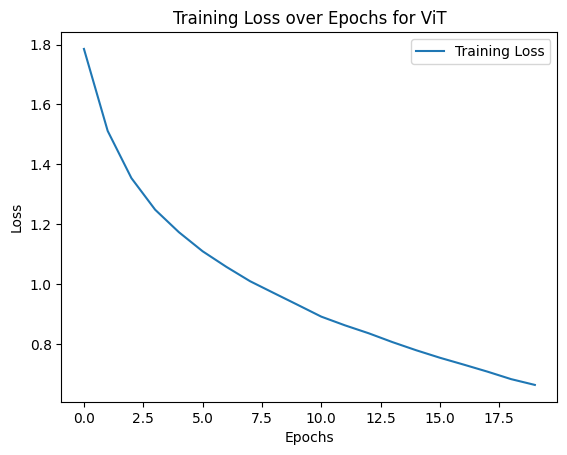

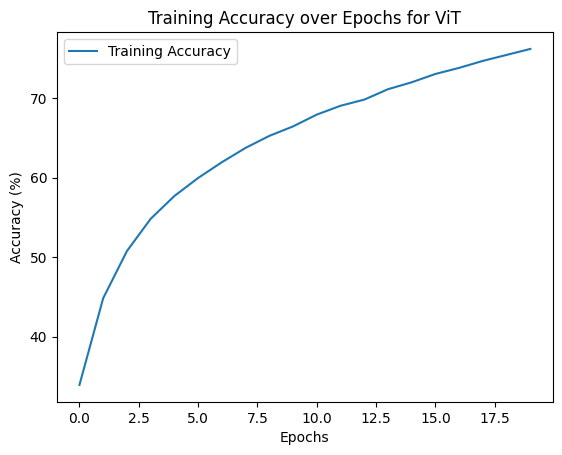

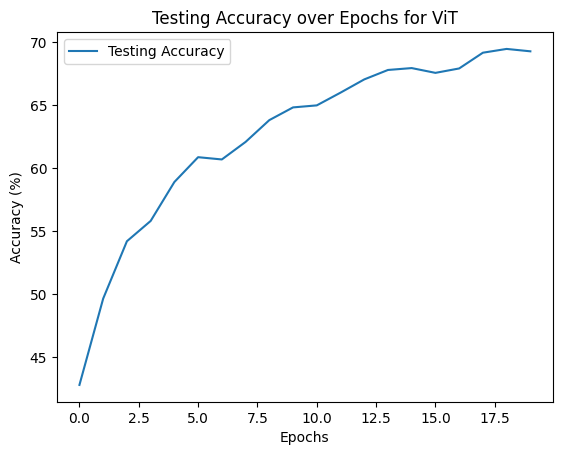

In [17]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

learning_rate = 0.0001 # best LR found in previous step
# Implement a ViT with default config. 
model = VisionTransformer()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# check if cuda:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# train over 20 epochs:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss_value = loss(outputs, labels)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss_value.item() * images.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

    epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
    epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total * 100.0
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy: {test_accuracy:.2f}%")

# plots:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss over Epochs for ViT')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs for ViT')
plt.legend()
plt.show()

plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy over Epochs for ViT')
plt.legend()
plt.show()

# plot training loss over epochs
# plot training and testing accuracy over epochs
# compare with CNN models and discuss observations:
    # which model performs better?
    # which model converges faster?


In [25]:
### NUM_LAYERS = 8

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
class PatchEmbedding(nn.Module):
    """
    Splits the image into patches and embeds them.
    """
    def __init__(self, in_channels=3, patch_size=4, emb_size=128, img_size=32):
        super().__init__()
        self.patch_size = patch_size
        # We use a simple conv layer to perform patchify + embedding in one step.
        self.proj = nn.Conv2d(in_channels, emb_size,
        kernel_size=patch_size,
        stride=patch_size)
        # Number of patches
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        # Positional embedding
        self.pos_emb = nn.Parameter(torch.zeros(1, num_patches + 1, emb_size))

    def forward(self, x):
        """
        x shape: (B, 3, 32, 32)
        returns: (B, N+1, emb_size)
        """
        B = x.size(0)
        # Conv2d -> (B, emb_size, H’, W’), with H’ and W’ = 32 // patch_size
        x = self.proj(x) # (B, emb_size, H’, W’)
        x = x.flatten(2) # (B, emb_size, H’*W’)
        x = x.transpose(1, 2) # (B, H’*W’, emb_size)
        # Class token
        cls_token = self.cls_token.expand(B, -1, -1) # (B, 1, emb_size)
        x = torch.cat([cls_token, x], dim=1) # (B, N+1, emb_size)
        # Add positional embedding
        x = x + self.pos_emb[:, : x.size(1), :]
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        self.qkv = nn.Linear(emb_size, 3 * emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        # x shape: (B, N, emb_size)
        B, N, _ = x.shape
        qkv = self.qkv(x) # (B, N, 3*emb_size)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # each: (B, num_heads, N, head_dim)
        # Scaled Dot-Product Attention
        # scores shape: (B, num_heads, N, N)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = torch.softmax(scores, dim=-1)
        att = self.att_drop(att)
        # out shape: (B, num_heads, N, head_dim)
        out = torch.matmul(att, v)
        # Combine heads
        out = out.transpose(1, 2) # (B, N, num_heads, head_dim)
        out = out.flatten(2) # (B, N, emb_size)
        out = self.projection(out)
        return out

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, expansion=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadSelfAttention(emb_size, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_size)

        # Feed-forward network
        self.ffn = nn.Sequential(
        nn.Linear(emb_size, expansion * emb_size),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(expansion * emb_size, emb_size)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # Attention block
        x_res = x
        x = self.norm1(x)
        x = self.attn(x)
        x = x_res + self.drop(x)
        # Feed-forward block
        x_res = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = x_res + self.drop(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(self,
        in_channels=3,
        patch_size=4,
        emb_size=128,
        img_size=32,
        num_heads=4,
        num_layers=8,
        num_classes=10,
        dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size,
        img_size)
        self.encoder = nn.Sequential(*[
        TransformerEncoderBlock(
        emb_size=emb_size,
        num_heads=num_heads,
        expansion=4,
        dropout=dropout
        ) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(emb_size)
        self.cls_head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        # x shape: (B, 3, 32, 32)
        x = self.patch_embed(x) # (B, N+1, emb_size)
        x = self.encoder(x) # (B, N+1, emb_size)
        x = self.norm(x) # (B, N+1, emb_size)aa
        # The first token is the class token
        cls_token_final = x[:, 0]
        out = self.cls_head(cls_token_final) # (B, num_classes)
        return out

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:25<00:00, 31.13batch/s]


Epoch [1/20], Loss: 1.7465, Accuracy: 35.79%
Test Accuracy: 44.42%


Epoch 2/20: 100%|██████████| 782/782 [00:26<00:00, 29.39batch/s]


Epoch [2/20], Loss: 1.4493, Accuracy: 47.46%
Test Accuracy: 51.04%


Epoch 3/20: 100%|██████████| 782/782 [00:26<00:00, 29.67batch/s]


Epoch [3/20], Loss: 1.2884, Accuracy: 53.19%
Test Accuracy: 55.98%


Epoch 4/20: 100%|██████████| 782/782 [00:24<00:00, 32.26batch/s]


Epoch [4/20], Loss: 1.1802, Accuracy: 57.19%
Test Accuracy: 56.83%


Epoch 5/20: 100%|██████████| 782/782 [00:23<00:00, 33.12batch/s]


Epoch [5/20], Loss: 1.1027, Accuracy: 60.00%
Test Accuracy: 59.64%


Epoch 6/20: 100%|██████████| 782/782 [00:22<00:00, 35.18batch/s]


Epoch [6/20], Loss: 1.0332, Accuracy: 62.61%
Test Accuracy: 61.51%


Epoch 7/20: 100%|██████████| 782/782 [00:22<00:00, 35.52batch/s]


Epoch [7/20], Loss: 0.9833, Accuracy: 64.62%
Test Accuracy: 63.72%


Epoch 8/20: 100%|██████████| 782/782 [00:22<00:00, 35.25batch/s]


Epoch [8/20], Loss: 0.9326, Accuracy: 66.57%
Test Accuracy: 65.19%


Epoch 9/20: 100%|██████████| 782/782 [00:22<00:00, 35.20batch/s]


Epoch [9/20], Loss: 0.8897, Accuracy: 68.16%
Test Accuracy: 64.72%


Epoch 10/20: 100%|██████████| 782/782 [00:22<00:00, 34.32batch/s]


Epoch [10/20], Loss: 0.8535, Accuracy: 69.42%
Test Accuracy: 66.51%


Epoch 11/20: 100%|██████████| 782/782 [00:22<00:00, 34.05batch/s]


Epoch [11/20], Loss: 0.8164, Accuracy: 70.73%
Test Accuracy: 67.02%


Epoch 12/20: 100%|██████████| 782/782 [00:22<00:00, 35.05batch/s]


Epoch [12/20], Loss: 0.7821, Accuracy: 72.10%
Test Accuracy: 67.11%


Epoch 13/20: 100%|██████████| 782/782 [00:22<00:00, 34.76batch/s]


Epoch [13/20], Loss: 0.7479, Accuracy: 73.32%
Test Accuracy: 69.14%


Epoch 14/20: 100%|██████████| 782/782 [00:24<00:00, 31.57batch/s]


Epoch [14/20], Loss: 0.7168, Accuracy: 74.58%
Test Accuracy: 69.32%


Epoch 15/20: 100%|██████████| 782/782 [00:22<00:00, 34.42batch/s]


Epoch [15/20], Loss: 0.6870, Accuracy: 75.60%
Test Accuracy: 70.03%


Epoch 16/20: 100%|██████████| 782/782 [00:22<00:00, 34.50batch/s]


Epoch [16/20], Loss: 0.6638, Accuracy: 76.27%
Test Accuracy: 70.44%


Epoch 17/20: 100%|██████████| 782/782 [00:24<00:00, 32.49batch/s]


Epoch [17/20], Loss: 0.6303, Accuracy: 77.63%
Test Accuracy: 69.78%


Epoch 18/20: 100%|██████████| 782/782 [00:24<00:00, 32.37batch/s]


Epoch [18/20], Loss: 0.6071, Accuracy: 78.29%
Test Accuracy: 70.92%


Epoch 19/20: 100%|██████████| 782/782 [00:22<00:00, 34.68batch/s]


Epoch [19/20], Loss: 0.5818, Accuracy: 79.46%
Test Accuracy: 71.02%


Epoch 20/20: 100%|██████████| 782/782 [00:22<00:00, 34.58batch/s]


Epoch [20/20], Loss: 0.5579, Accuracy: 80.12%
Test Accuracy: 71.17%


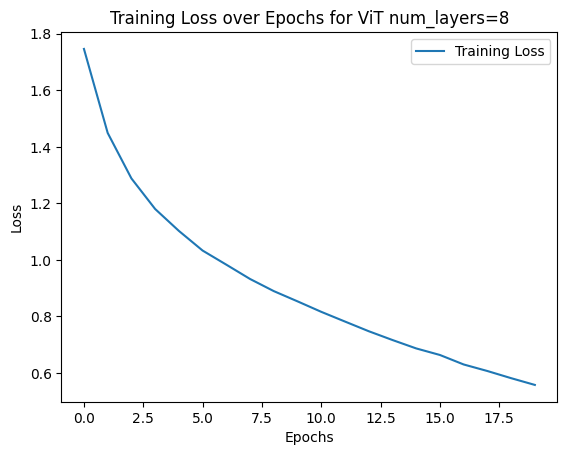

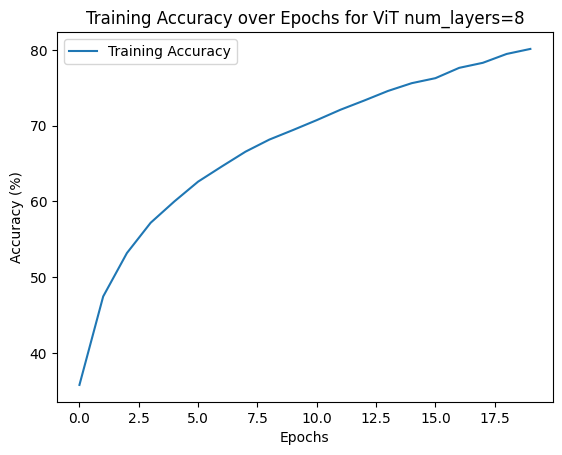

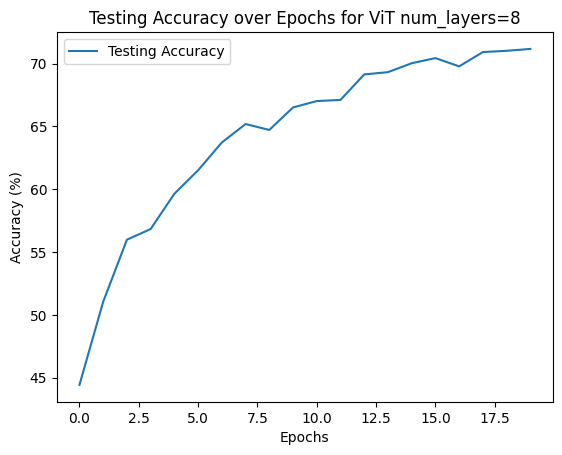

In [26]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

learning_rate = 0.0001 # best LR found in previous step
# Implement a ViT with default config. 
model = VisionTransformer()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# check if cuda:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# train over 20 epochs:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss_value = loss(outputs, labels)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss_value.item() * images.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

    epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
    epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total * 100.0
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy: {test_accuracy:.2f}%")

# plots:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss over Epochs for ViT num_layers=8')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs for ViT num_layers=8')
plt.legend()
plt.show()

plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy over Epochs for ViT num_layers=8')
plt.legend()
plt.show()

# plot training loss over epochs
# plot training and testing accuracy over epochs
# compare with CNN models and discuss observations:
    # which model performs better?
    # which model converges faster?
